# Etapes de pre-processing pour l'entrainment de CNN afin de créer un classifieur de champignons comestibles / non-comestibles

L'objectif de ce notebook est de réaliser les étapes de preprocessing commune pour l'entrainement de modèles de type CNN.
Les inputs de ce notebook sont :
- le dataset d'images nettoyé et le fichier .csv correspondant au dataset d'images qui sera utilisé pour les parties train et test,
- le dataset de validation avec le fichier .csv associé.

Les ouputs de ce notebook sont en fonction de l'utilisation de flow_from_dataframe ou flow_from_directory.

Si usage de flow_from_dataframe :
- les dataframes train, test et val pour l'entrainement de modèles

Si usage de flow_from_directory :
- une arborescence de type
dataset_for_binary_classification
- train
    - edible
    - inedible
- test
    - edible
    - inedible
- validation
    - edible
    - inedible

Les dossiers edible / inedible des dataset train et test seront equilibré (meme nombre d'images) via une réduction de données. Les images de l'ensemble des datasets seront redimentionnées au format (224,224,3).

In [69]:
import os
import shutil
import pandas as pd
import numpy as np
from IPython.display import display
import matplotlib.pyplot as plt
%matplotlib inline


from sklearn.model_selection import train_test_split
import random
import PIL.Image

In [94]:
# création des chemins d'accés vers les fichiers sources

training_dataset = r'C:\Users\renamedadmin\Documents\Formation_Datascience\Projet_Datascientest_Champignons\Dossier_technique\02_Pieces_constitutives\Dataset\cleaned_cleaned_dataset.csv'
training_images = r'C:\Users\renamedadmin\Documents\Formation_Datascience\Projet_Datascientest_Champignons\Dossier_technique\02_Pieces_constitutives\Dataset\dataset_cleaned'
validation_dataset = r'C:\Users\renamedadmin\Documents\Formation_Datascience\Projet_Datascientest_Champignons\Dossier_technique\02_Pieces_constitutives\Dataset\validation_dataset_wildfooduk_cleaned.csv'
validation_images = r'C:\Users\renamedadmin\Documents\Formation_Datascience\Projet_Datascientest_Champignons\Dossier_technique\02_Pieces_constitutives\Dataset\val_dataset'

In [87]:
# import des .csv
train_test_dataset = pd.read_csv(training_dataset)
val_dataset = pd.read_csv(validation_dataset)


display(train_test_dataset.head(), val_dataset.head())

,filename,kingdom,phylum,classes,order,family,genus,species,edible
0,1.jpg,Fungi,Ascomycota,Sordariomycetes,Xylariales,Xylariaceae,Xylaria,Xylaria polymorpha,0
1,2.jpg,Fungi,Ascomycota,Sordariomycetes,Xylariales,Xylariaceae,Xylaria,Xylaria magnoliae,0
2,3.jpg,Fungi,Ascomycota,Sordariomycetes,Xylariales,Xylariaceae,Xylaria,Xylaria hypoxylon,0
3,4.jpg,Fungi,Ascomycota,Sordariomycetes,Xylariales,Xylariaceae,Xylaria,Xylaria hypoxylon,0
4,6.jpg,Fungi,Basidiomycota,Agaricomycetes,Agaricales,Mycenaceae,Xeromphalina,Xeromphalina campanella,0


,filename,edible,kingdom,family,phylum,species,classes,genus,order
0,1000000.jpg,1,Fungi,Agaricaceae,Basidiomycota,Agaricus subrufescens,Agaricomycetes,Agaricus,Agaricales
1,1000001.jpg,1,Fungi,Agaricaceae,Basidiomycota,Agaricus subrufescens,Agaricomycetes,Agaricus,Agaricales
2,1000002.jpg,1,Fungi,Agaricaceae,Basidiomycota,Agaricus subrufescens,Agaricomycetes,Agaricus,Agaricales
3,1000003.jpg,1,Fungi,Agaricaceae,Basidiomycota,Agaricus subrufescens,Agaricomycetes,Agaricus,Agaricales
4,1000004.jpg,1,Fungi,Agaricaceae,Basidiomycota,Agaricus subrufescens,Agaricomycetes,Agaricus,Agaricales


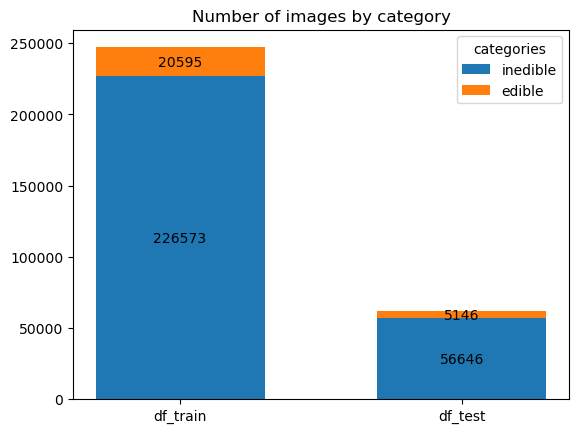

In [88]:
# séparation du train_test_dataset en 2 parties avec test = 20%
df_train, df_test = train_test_split(train_test_dataset, test_size=0.2, random_state = 3)

# affichage d'un countplot de répartition des labels dans les datasets
# génération des données du graph
inedible = []
edible = []

dataframes = [df_train, df_test]
for dataframe in dataframes:
    count_inedible = dataframe['edible'].value_counts()[0]
    inedible.append(count_inedible)
    count_edible = dataframe['edible'].value_counts()[1]
    edible.append(count_edible)   

data = ['df_train', 'df_test']
edibility = {'inedible': inedible, 'edible' : edible}

colonnes = ['df_train', 'df_test']
edibility_counts = {
    'inedible': inedible,
    'edible': edible
}

width = 0.6
fig, ax = plt.subplots()
bottom = np.zeros(2)
for i, j in edibility.items():
    p = ax.bar(data, j, width, label=i, bottom=bottom)
    bottom += j
    ax.bar_label(p, label_type='center')
ax.set_title('Number of images by category')
ax.legend(title = 'categories')

plt.show()

# les datasets sont déséquilibrés.
# un sous_échantillonnage des 2 datasets va être réalisés car le nombre d'images et trop important.

## Avec flow_from_dataframe 

In [89]:
# équilibrage des données par échantillonge aléatoire des dataframes

# suppression des colonnes inutiles
df_train = df_train.drop(columns = ["kingdom", "phylum", "family", "order", "genus", "species", "classes"], axis = 1)
df_test = df_test.drop(columns = ["kingdom", "phylum", "family", "order", "genus", "species", "classes"], axis = 1)

# séparation des dataframes selon le caractère "edible"
df_train_edible = df_train.loc[df_train["edible"] == 1]
df_train_inedible = df_train.loc[df_train["edible"] == 0]
df_test_edible = df_test.loc[df_test["edible"] == 1]
df_test_inedible = df_test.loc[df_test["edible"] == 0]

# decompte du nombr ed'individus à conserver par dataset
count_train_edible = len(df_train_edible)
count_test_edible = len(df_test_edible)

# suppression de individus
df_train_inedible_resample = df_train_inedible.sample(n = count_train_edible)
df_test_inedible_resample = df_test_inedible.sample(n = count_test_edible)

# concatenation des dataframes et mélange
df_train_resample = pd.concat([df_train_edible, df_train_inedible_resample])
df_train_resample = df_train_resample.sample(frac = 1.0)
df_test_resample = pd.concat([df_test_edible, df_test_inedible_resample])
df_test_resample = df_test_resample.sample(frac = 1.0)

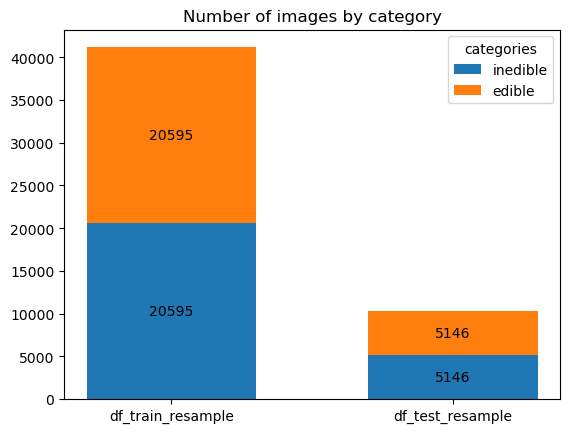

In [90]:
# affichage d'un countplot de répartition des labels dans les datasets aprés rééquilibrage
# génération des données du graph
inedible = []
edible = []

dataframes = [df_train_resample, df_test_resample]
for dataframe in dataframes:
    count_inedible = dataframe['edible'].value_counts()[0]
    inedible.append(count_inedible)
    count_edible = dataframe['edible'].value_counts()[1]
    edible.append(count_edible)   

data = ['df_train_resample', 'df_test_resample']
edibility = {'inedible': inedible, 'edible' : edible}

colonnes = ['df_train_resample', 'df_test_resample']
edibility_counts = {
    'inedible': inedible,
    'edible': edible
}

width = 0.6
fig, ax = plt.subplots()
bottom = np.zeros(2)
for i, j in edibility.items():
    p = ax.bar(data, j, width, label=i, bottom=bottom)
    bottom += j
    ax.bar_label(p, label_type='center')
ax.set_title('Number of images by category')
ax.legend(title = 'categories')

plt.show()

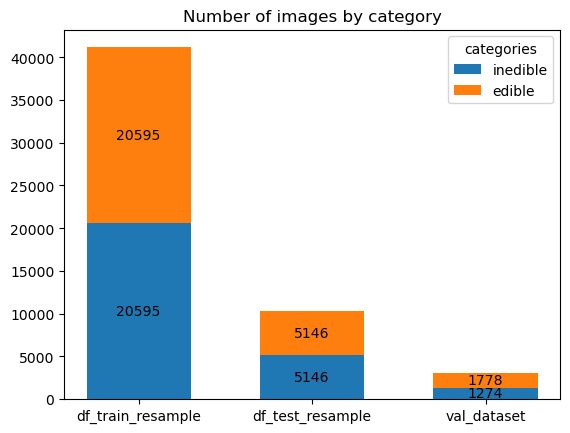

In [99]:
# pour le dataset de validation
val_dataset = pd.read_csv(validation_dataset)
val_dataset.head()

# suppression des colonnes inutiles
val_dataset = val_dataset.drop(columns = ["kingdom", "phylum", "family", "order", "genus", "species", "classes"], axis = 1)

# affichage d'un countplot de répartition des labels dans les datasets train, test et val
# génération des données du graph
inedible = []
edible = []

dataframes = [df_train_resample, df_test_resample, val_dataset]
for dataframe in dataframes:
    count_inedible = dataframe['edible'].value_counts()[0]
    inedible.append(count_inedible)
    count_edible = dataframe['edible'].value_counts()[1]
    edible.append(count_edible)   

data = ["df_train_resample", "df_test_resample", "val_dataset"]
edibility = {'inedible': inedible, 'edible' : edible}

colonnes = ["df_train_resample", "df_test_resample", "val_dataset"]
edibility_counts = {
    'inedible': inedible,
    'edible': edible
}

width = 0.6
fig, ax = plt.subplots()
bottom = np.zeros(3)
for i, j in edibility.items():
    p = ax.bar(data, j, width, label=i, bottom=bottom)
    bottom += j
    ax.bar_label(p, label_type='center')
ax.set_title('Number of images by category')
ax.legend(title = 'categories')

plt.show()

In [100]:
# sauvegarde des dataframes pour entrainement et validation de modeles CNN
train_path = os.path.join(os.path.dirname(training_images), "train_FFDataframe_full_undersampling.csv")
test_path = os.path.join(os.path.dirname(training_images), "test_FFDataframe_full_undersampling.csv")
validation_path = os.path.join(os.path.dirname(training_images), "val_FFDataframe_full.csv")
df_train_resample.to_csv(train_path)
df_test_resample.to_csv(test_path)
val_dataset.to_csv(validation_path)

In [106]:
# création du dossier d'images associé avec resize des images en 224x224
os.mkdir(os.path.join(os.path.dirname(training_images), "FFD_images_dataset"))
FFD_images_dataset = os.path.join(os.path.dirname(training_images), "FFD_images_dataset")

# copie des images dans le dossier
images_train = df_train_resample.filename.tolist()
images_test = df_test_resample.filename.tolist()
images_validation = val_dataset.filename.tolist()

for image_name in images_train :    
    original_image_path = os.path.join(training_images, image_name)
    new_image_path = os.path.join(FFD_images_dataset, image_name)
    if os.path.exists(original_image_path):
        shutil.copy(original_image_path, new_image_path)

for image_name in images_test :    
    original_image_path = os.path.join(training_images, image_name)
    new_image_path = os.path.join(FFD_images_dataset, image_name)
    if os.path.exists(original_image_path):
        shutil.copy(original_image_path, new_image_path)

for image_name in images_validation :    
    original_image_path = os.path.join(validation_images, image_name)
    new_image_path = os.path.join(FFD_images_dataset, image_name)
    if os.path.exists(original_image_path):
        shutil.copy(original_image_path, new_image_path)

# resize des images
# creation d'une fonction permettant de redimensionner les images d'un dossier
def resize_images(folder, W, H):
    '''
    Args :
    folder : dossier à cibler
    W : width cible des images
    H : height cible des images
    '''
    images_list = os.listdir(folder)
    for image in images_list:
        image_load = PIL.Image.open(os.path.join(folder, image))
        image_resize = image_load.resize((W, H))
        image_resize.save(os.path.join(folder, image))
        
resize_images(FFD_images_dataset, 224, 224)

## Avec flow_from_directory 

In [32]:
# création de l'arboresence
directory = os.path.dirname(training_images)
os.mkdir(os.path.join(directory, 'dataset_for_BC_by_CNN'))
dataset_for_BC_by_CNN = os.path.join(directory, 'dataset_for_BC_by_CNN')



In [33]:
# pour la partie train

#création de l'arborescence
os.mkdir(os.path.join(dataset_for_BC_by_CNN, 'train'))
train_images = os.path.join(dataset_for_BC_by_CNN, 'train')
os.mkdir(os.path.join(train_images, 'edible'))
os.mkdir(os.path.join(train_images, 'inedible'))
edible_train_folder = os.path.join(train_images, 'edible')
inedible_train_folder = os.path.join(train_images, 'inedible')

# extraction d'une liste des images de champignons comestibles
edible_df_train = df_train.loc[df_train["edible"] == 1]
# extraction d'une liste des images de champignons non-comestibles
inedible_df_train = df_train.loc[df_train["edible"] == 0]

# création des listes d'images à copier
edible_train_images = edible_df_train['filename'].tolist()
inedible_train_images = inedible_df_train['filename'].tolist()

# copie des images 
# itération sur les noms d'images de champignons comestibles du dataset train
for image_name in edible_train_images :    
    # trouver l'image dans le dossier d'origine
    original_image_path = os.path.join(training_images, image_name)
    # copie de l'image dans le dossier de destination
    new_image_path = os.path.join(edible_train_folder, image_name)
    if os.path.exists(original_image_path):
        shutil.copy(original_image_path, new_image_path)

# itération sur les noms d'images de champignons non-comestibles du dataset train
for image_name in inedible_train_images :    
    # trouver l'image dans le dossier d'origine
    original_image_path = os.path.join(training_images, image_name)
    # copie de l'image dans le dossier de destination
    new_image_path = os.path.join(inedible_train_folder, image_name)
    if os.path.exists(original_image_path):
        shutil.copy(original_image_path, new_image_path)


In [34]:
# pour la partie test

#création de l'arborescence
os.mkdir(os.path.join(dataset_for_BC_by_CNN, 'test'))
test_images = os.path.join(dataset_for_BC_by_CNN, 'test')
os.mkdir(os.path.join(test_images, 'edible'))
os.mkdir(os.path.join(test_images, 'inedible'))
edible_test_folder = os.path.join(test_images, 'edible')
inedible_test_folder = os.path.join(test_images, 'inedible')

# extraction d'une liste des images
edible_df_test = df_test.loc[df_test["edible"] == 1]
inedible_df_test = df_test.loc[df_test["edible"] == 0]
edible_test_images = edible_df_test['filename'].tolist()
inedible_test_images = inedible_df_test['filename'].tolist()

# copie des images 
for image_name in edible_test_images :    
    original_image_path = os.path.join(training_images, image_name)
    new_image_path = os.path.join(edible_test_folder, image_name)
    if os.path.exists(original_image_path):
        shutil.copy(original_image_path, new_image_path)

for image_name in inedible_test_images :    
    original_image_path = os.path.join(training_images, image_name)
    new_image_path = os.path.join(inedible_test_folder, image_name)
    if os.path.exists(original_image_path):
        shutil.copy(original_image_path, new_image_path)


In [35]:
# pour la partie validation

#création de l'arborescence
os.mkdir(os.path.join(dataset_for_BC_by_CNN, 'val'))
val_images = os.path.join(dataset_for_BC_by_CNN, 'val')
os.mkdir(os.path.join(val_images, 'edible'))
os.mkdir(os.path.join(val_images, 'inedible'))
edible_val_folder = os.path.join(val_images, 'edible')
inedible_val_folder = os.path.join(val_images, 'inedible')

# extraction d'une liste des images
edible_df_val = val_dataset.loc[val_dataset["edible"] == 1]
inedible_df_val = val_dataset.loc[val_dataset["edible"] == 0]
edible_val_images = edible_df_val['filename'].tolist()
inedible_val_images = inedible_df_val['filename'].tolist()

# copie des images 
for image_name in edible_val_images :    
    original_image_path = os.path.join(validation_images, image_name)
    new_image_path = os.path.join(edible_val_folder, image_name)
    if os.path.exists(original_image_path):
        shutil.copy(original_image_path, new_image_path)

for image_name in inedible_val_images :    
    original_image_path = os.path.join(validation_images, image_name)
    new_image_path = os.path.join(inedible_val_folder, image_name)
    if os.path.exists(original_image_path):
        shutil.copy(original_image_path, new_image_path)


In [37]:
# affichage du nombre d'image dans chaque dossier avant l'étape d'équilibrage
nb_image_edible_train = len(os.listdir(edible_train_folder))
nb_image_inedible_train = len(os.listdir(inedible_train_folder))
nb_image_edible_test = len(os.listdir(edible_test_folder))
nb_image_inedible_test = len(os.listdir(inedible_test_folder))
nb_image_edible_val = len(os.listdir(edible_val_folder))
nb_image_inedible_val = len(os.listdir(inedible_val_folder))



print("Nombre d'images dans le jeu de données train_edible avant équilibrage :", nb_image_edible_train)
print("Nombre d'images dans le jeu de données train_inedible avant équilibrage :", nb_image_inedible_train)
print("Nombre d'images dans le jeu de données test_edible avant équilibrage :", nb_image_edible_test)
print("Nombre d'images dans le jeu de données test_inedible avant équilibrage :", nb_image_inedible_test)
print("Nombre d'images dans le jeu de données val_edible avant équilibrage :", nb_image_edible_val)
print("Nombre d'images dans le jeu de données val_inedible avant équilibrage :", nb_image_inedible_val)

Nombre d'images dans le jeu de données train_edible avant équilibrage : 20595
Nombre d'images dans le jeu de données train_inedible avant équilibrage : 226573
Nombre d'images dans le jeu de données test_edible avant équilibrage : 5146
Nombre d'images dans le jeu de données test_inedible avant équilibrage : 56646
Nombre d'images dans le jeu de données val_edible avant équilibrage : 1778
Nombre d'images dans le jeu de données val_inedible avant équilibrage : 1274


In [52]:
# Equilibrage des jeux de données par sous-échantillonnage des différents dossiers inedible
image_train_to_delete = nb_image_inedible_train - nb_image_edible_train
image_test_to_delete = nb_image_inedible_test - nb_image_edible_test

# collecte des noms d'images à supprimer
random_image_train_to_delete = random.sample(os.listdir(inedible_train_folder), image_train_to_delete)
random_image_test_to_delete = random.sample(os.listdir(inedible_test_folder), image_test_to_delete)

# suppression des images
for image in random_image_train_to_delete:
    os.remove(os.path.join(inedible_train_folder, image))
for image in random_image_test_to_delete:
    os.remove(os.path.join(inedible_test_folder, image))

In [53]:
# affichage du nombre d'image dans chaque dossier apres l'étape d'équilibrage
nb_image_edible_train = len(os.listdir(edible_train_folder))
nb_image_inedible_train = len(os.listdir(inedible_train_folder))
nb_image_edible_test = len(os.listdir(edible_test_folder))
nb_image_inedible_test = len(os.listdir(inedible_test_folder))
nb_image_edible_val = len(os.listdir(edible_val_folder))
nb_image_inedible_val = len(os.listdir(inedible_val_folder))



print("Nombre d'images dans le jeu de données train_edible aprés équilibrage :", nb_image_edible_train)
print("Nombre d'images dans le jeu de données train_inedible aprés équilibrage :", nb_image_inedible_train)
print("Nombre d'images dans le jeu de données test_edible aprés équilibrage :", nb_image_edible_test)
print("Nombre d'images dans le jeu de données test_inedible aprés équilibrage :", nb_image_inedible_test)
print("Nombre d'images dans le jeu de données val_edible aprés équilibrage :", nb_image_edible_val)
print("Nombre d'images dans le jeu de données val_inedible aprés équilibrage :", nb_image_inedible_val)

Nombre d'images dans le jeu de données train_edible aprés équilibrage : 20595
Nombre d'images dans le jeu de données train_inedible aprés équilibrage : 20595
Nombre d'images dans le jeu de données test_edible aprés équilibrage : 5146
Nombre d'images dans le jeu de données test_inedible aprés équilibrage : 5146
Nombre d'images dans le jeu de données val_edible aprés équilibrage : 1778
Nombre d'images dans le jeu de données val_inedible aprés équilibrage : 1274


In [66]:
# resize des images
resize_image(inedible_train_folder, 224, 224)
resize_image(edible_train_folder, 224, 224)
resize_image(inedible_test_folder, 224, 224)
resize_image(edible_test_folder, 224, 224)
resize_image(inedible_val_folder, 224, 224)
resize_image(edible_val_folder, 224, 224)